In [ ]:
from typing import Optional, Dict, Any
import pandas as pd
import numpy as np
import optuna
import shap

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
class FeatureEngineering:
    
    def ship_related_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Splits 'Cabin' into 'Deck' and 'Cabin_part'.
        
        Args:
            data (pd.DataFrame): The input DataFrame containing the 'Cabin' column.

        Returns:
            pd.DataFrame: The updated DataFrame with 'Deck' and 'Cabin_part' columns.
        """

        # Split 'Cabin' column by '/' and assign first and third parts to 'Deck' and 'Cabin_part'
        data[['Deck', 'Cabin_part']] = data['Cabin'].str.split("/", expand=True).iloc[:, [0, 2]]


        return data

    def passenger_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Creates passenger-related features including group size and family details.
        
        Args:
            data (pd.DataFrame): The input DataFrame containing passenger information.

        Returns:
            pd.DataFrame: The updated DataFrame with additional passenger features.
        """
        # Count number of passengers per 'Cabin' and assign result to a new column
        data['NUMBER_OF_PASSENGERS_PER_CABIN'] = data.groupby('Cabin')['PassengerId'].transform('count')

        # Count passengers per group by splitting 'PassengerId' and assigning result to a new column
        data['NUMBER_OF_PASSENGERS_PER_GROUP'] = data['PassengerId'].str.split("_").str[0].map(
            data['PassengerId'].str.split("_").str[0].value_counts())

        # Calculate mean age per group and assign to a new column
        data['Avg_Age_Per_Group'] = data.groupby('NUMBER_OF_PASSENGERS_PER_GROUP')['Age'].transform('mean')
        

        # Number of people in a family
        data['FAMILY'] = data.groupby(by='FAMILY_ID')['FAMILY_ID'].transform('count')

        # Number of passengers in CryoSleep per HomePlanet
        data['Cryo_Count'] = data.groupby(by='HomePlanet')['CryoSleep'].transform('count')

        return data

    def service_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculates service-related spending features more efficiently.

        Args:
            data (pd.DataFrame): Input DataFrame containing service spending information.

        Returns:
            pd.DataFrame: Updated DataFrame with service-related features.
        """
        service_columns = ['RoomService', 'Spa', 'FoodCourt', 'ShoppingMall', 'VRDeck']

        # Compute aggregate spending features at different levels
        passenger_spending = data.groupby('PassengerId')[service_columns].agg(['mean'])
        family_spending = data.groupby('FAMILY_ID')[service_columns].agg(['mean'])
        deck_spending = data.groupby('Deck')[service_columns].agg(['mean'])
        family_spending_sum = data.groupby('FAMILY_ID')[service_columns].agg(['sum'])

        passenger_spending.columns = [f"{stat}_Spending_On_{col}_Pass" for col, stat in passenger_spending.columns]
        family_spending.columns = [f"{stat}_Spending_On_{col}_Fam" for col, stat in family_spending.columns]
        deck_spending.columns = [f"{stat}_Spending_On_{col}_Deck" for col, stat in deck_spending.columns]
        family_spending_sum.columns = [f"{stat}_Spending_On_{col}_Fam_SUM" for col, stat in family_spending_sum.columns]

        data['TotalSpending'] = data[service_columns].sum(axis=1)
        data["MeanSpending_HomePlanet"] = data.groupby("HomePlanet")["TotalSpending"].transform("mean")
        data["MeanSpending_Destination"] = data.groupby("Destination")["TotalSpending"].transform("mean")
        data["TotalSpending_Family"] = data.groupby("FAMILY")["TotalSpending"].transform("sum")
        data['SPEND_PER_FAMILY'] = data['TotalSpending'] / data['FAMILY']
        data["isHighSpender"] = (data["TotalSpending"] > data["TotalSpending"].median()).astype(int)

        # Merge computed statistics back to the original DataFrame
        data = data.merge(passenger_spending, on='PassengerId', how='left')
        data = data.merge(family_spending, on='FAMILY_ID', how='left')
        data = data.merge(deck_spending, on='Deck', how='left')
        data = data.merge(family_spending_sum, on='FAMILY_ID', how='left')

        # Create binary and categorical features for age column
        data['isMinor'] = (data['Age'] < 18).astype(int)
        data['Age_Cat'] = pd.cut(data['Age'], bins=[0, 12, 17, 64, float('inf')], labels=['Child', 'Teen', 'Adult', 'Senior'])

        # Convert categorical features to dummy variables (optional)
        data = pd.get_dummies(data, columns=['Age_Cat'], dtype=int)

        return data
    
    def destination_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Creates destination-related features.
        
        Args:
            data (pd.DataFrame): The input DataFrame containing destination related features.

        Returns:
            pd.DataFrame: The updated DataFrame with destination related features.
        """
        # Count the number of occurrences of each 'Destination' by 'HomePlanet'
        data['Destination_Count_By_HomePlanet'] = data.groupby('Destination')['HomePlanet'].transform('count')

        return data 

    
    def missing_value_imputation(self, data: pd.DataFrame, n_neighbors: int, columns_to_impute: list) -> pd.DataFrame:
        """Imputes missing values using the KNNImputer.
        
        Args:
            data (pd.DataFrame): The DataFrame containing missing values.
            n_neighbors (int): Number of neighbors for KNNImputer.
            columns_to_impute (list): Columns to be imputed.

        Returns:
            pd.DataFrame: The DataFrame with missing values imputed.
        """
        # Extracting family id
        data['FAMILY_ID']  = data['PassengerId'].str[:4]
        
        # Create a mapping from family_id to known homeplanet (excluding NaNs)
        family_planet_map = data.groupby('FAMILY_ID')['HomePlanet'].apply(lambda x: x.dropna().unique())
        
        # Fill missing values if a family member has a known homeplanet
        data['HomePlanet'] = data.apply(lambda row: family_planet_map[row['FAMILY_ID']][0] 
                                    if pd.isna(row['HomePlanet']) and len(family_planet_map[row['FAMILY_ID']]) > 0 
                                    else row['HomePlanet'], axis=1)
    
        # Initialize the KNN imputer with the specified number of neighbors
        imputer = KNNImputer(n_neighbors=n_neighbors)


        # Select only the columns to be imputed
        data_to_impute = data[columns_to_impute]

        # Fit and transform the data for imputation, then update original data
        data_imputed = pd.DataFrame(imputer.fit_transform(data_to_impute), columns=columns_to_impute, index=data.index)
        data.update(data_imputed)

        # Identify categorical columns
        cat_cols = data.select_dtypes(include=['object']).columns

        # Initialize SimpleImputer for categorical features
        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Impute categorical features using mode and ensure DataFrame structure is maintained
        imputed_cat_data = pd.DataFrame(
            cat_imputer.fit_transform(data[cat_cols]),
            columns=cat_cols,
            index=data.index
        )

        # Convert the categorical columns back to string type (if needed)
        data = data.astype(str)

        # Combine imputed categorical features with the rest of the DataFrame
        data = pd.concat([imputed_cat_data, data.drop(columns=cat_cols)], axis=1)

        data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].astype('float32')
        
        return data

    def feature_pipeline(self, data: pd.DataFrame) -> pd.DataFrame:
        """Runs the full feature engineering pipeline on data.
        
        Args:
            data (pd.DataFrame): The input DataFrame to process.

        Returns:
            pd.DataFrame: The processed DataFrame with all features engineered.
        """
        # Apply each feature engineering function to the data
        data_processed = self.ship_related_features(data)
        data_processed = self.passenger_features(data_processed)
        data_processed = self.service_features(data_processed)
        data_processed = self.destination_features(data_processed)

        return data_processed
    
    def data_split(self, data: pd.DataFrame, features: list[str], target: str) -> tuple[pd.DataFrame, pd.Series]:
        """Splits the data into features and target.
        
        Args:
            data (pd.DataFrame): The input DataFrame containing features and target.
            features (list[str]): The list of feature column names.
            target (str): The name of the target column.

        Returns:
            tuple[pd.DataFrame, pd.Series]: A tuple containing the features DataFrame and target Series.
        """
        # Select the feature columns and target column from data
        X_train = data[features]
        y_train = data[target]

        return X_train, y_train
    
    def get_dummies(self, data: pd.DataFrame, dtype: type) -> pd.DataFrame:
        """Creates dummy variables for categorical features.
        
        Args:
            data (pd.DataFrame): The input DataFrame to create dummy variables from.
            dtype (type): The desired data type for the resulting dummy variables.

        Returns:
            pd.DataFrame: The DataFrame with dummy variables added.
        """
        # Convert categorical columns to dummy/one-hot encoded columns
        dummied_data = pd.get_dummies(data, dtype=dtype)
        
        return dummied_data

In [ ]:
class Modelling:
    """
    A class to handle machine learning model initialization and hyperparameter tuning using Optuna.

    Attributes:
        model (Any): The initialized machine learning model.
        available_models (Dict[str, Any]): A dictionary mapping model names to their respective classes.
    """

    def __init__(self):
        """
        Initializes the Modelling class and defines available models for initialization.
        """
        # No model initialized yet
        self.model = None

        # Dictionary to hold available model classes for initialization
        self.available_models = {
            'RandomForestClassifier': RandomForestClassifier, 
            'XGBClassifier': XGBClassifier,
            'LGBMClassifier': LGBMClassifier,
            'HistGradientBoostingClassifier': HistGradientBoostingClassifier,
            'GradientBoostingClassifier': GradientBoostingClassifier,
        }


    def initialize_model(self, model_name: str, params: Optional[Dict[str, Any]] = None) -> Any:
        """
        Initializes and returns a machine learning model based on the model_name.

        Args:
            model_name (str): Name of the model to initialize.
            params (Optional[Dict[str, Any]]): Hyperparameters for the model. Defaults to None.

        Returns:
            Any: An instance of the selected model.

        Raises:
            ValueError: If the model_name is not in available_models.
        """

        # Check if the model name is valid
        if model_name not in self.available_models:
            print(f"The {model_name} is not yet available, you can select a following model: {list(self.available_models.keys())}")
            raise ValueError(f"{model_name} is not a valid model.")
        
        # Initialize and return the model with given parameters, or empty dictionary if None
        return self.available_models[model_name](**(params or {}))
    
    def predict_test_set(self, model: Any, X_test: pd.DataFrame) -> np.ndarray:

        """
        Predicts the target variable for the given test set using the provided model.

        Args:
            model (Any): The trained model used for making predictions.
            X_test (pd.DataFrame): The test set features for which predictions are to be made.

        Returns:
            np.ndarray: The predicted values for the test set.
        """
        predictions = model.predict(X_test)
        return predictions

    def fit_model(self, model: Any, X_train: pd.DataFrame, y_train: pd.Series) -> Any:
        """
        Fits the provided model to the training data.

        Args:
            model (Any): The model to be trained.
            X_train (pd.DataFrame): The training set features.
            y_train (pd.Series): The target variable corresponding to the training set features.

        Returns:
            Any: The fitted model.
        """
        return model.fit(X_train, y_train)

        
    def tune_model(self, model_name: str, X_train: Any, y_train: Any, n_trials: int) -> Dict[str, Any]:
        """
        Tunes the specified model's hyperparameters using Optuna.

        Args:
            model_name (str): Name of the model to tune.
            X_train (Any): Training features.
            y_train (Any): Training labels.
            n_trials (int): Number of trials for hyperparameter tuning.

        Returns:
            Dict[str, Any]: The best parameters found during tuning.

        Raises:
            ValueError: If the model_name is not in available_models.
        """

        # Suppress Optuna's verbose logging
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        # Check if the model name is valid
        if model_name not in self.available_models:
            print(f"The {model_name} is not yet available, you can select a following model: {list(self.available_models.keys())}")
            raise ValueError(f"{model_name} is not a valid model.")

        # Choose the appropriate tuning method based on model name
        if model_name == 'RandomForestClassifier':
            return self.tune_random_forest(X_train, y_train, n_trials)

        elif model_name == 'XGBClassifier':
            return self.tune_xgb(X_train, y_train, n_trials)

        elif model_name == 'LGBMClassifier':
            return self.tune_lgbm(X_train, y_train, n_trials)
        
        elif model_name == 'HistGradientBoostingClassifier':
            return self.tune_hgbc(X_train, y_train, n_trials)
        
        elif model_name =='GradientBoostingClassifier':
            return self.tune_gbc(X_train, y_train, n_trials)

        else:
            raise ValueError(f"{model_name} is not a valid model.")

    def tune_random_forest(self, X_train: Any, y_train: Any, n_trials: int) -> Dict[str, Any]:
        """
        Tunes hyperparameters for the RandomForestClassifier.

        Args:
            X_train (Any): Training features.
            y_train (Any): Training labels.
            n_trials (int): Number of trials for hyperparameter tuning.

        Returns:
            Dict[str, Any]: The best parameters found during tuning.
        """

        # Define hyperparameters to tune
        def rfc_objective(trial):
            n_estimators = trial.suggest_int("n_estimators", 50, 500)
            max_depth = trial.suggest_int("max_depth", 3, 20)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
            bootstrap = trial.suggest_categorical("bootstrap", [True, False])
            criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
            max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 100)

            # Initialize model with suggested hyperparameters
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                bootstrap=bootstrap,
                criterion = criterion,
                max_leaf_nodes = max_leaf_nodes,
                random_state=42,
            )

             # Perform cross-validation and return mean accuracy
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(rf, X_train, y_train, cv=cv, scoring="accuracy", n_jobs = -1).mean()
            return score

        # Create and run an Optuna study
        rfc_study = optuna.create_study(direction="maximize")
        rfc_study.optimize(rfc_objective, n_trials=n_trials)

        print("Best parameters for RandomForestClassifier:", rfc_study.best_params)
        print("Best score for RandomForestClassifier:", rfc_study.best_value)

        return rfc_study.best_params

    def tune_xgb(self, X_train: Any, y_train: Any, n_trials: int) -> Dict[str, Any]:
        """
        Tunes hyperparameters for the XGBClassifier.

        Args:
            X_train (Any): Training features.
            y_train (Any): Training labels.
            n_trials (int): Number of trials for hyperparameter tuning.

        Returns:
            Dict[str, Any]: The best parameters found during tuning.
        """
        def xgb_objective(trial):
            n_estimators = trial.suggest_int("n_estimators", 50, 500)
            max_depth = trial.suggest_int("max_depth", 3, 15)
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
            subsample = trial.suggest_float("subsample", 0.5, 1.0)
            colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
            gamma = trial.suggest_float("gamma", 0, 5)
            reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
            reg_lambda = trial.suggest_float("reg_lambda", 0, 10)
            scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.5, 1.0)
            min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
            
            xgb = XGBClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                gamma=gamma,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                scale_pos_weight=scale_pos_weight,
                min_child_weight=min_child_weight,
                random_state=42,
            )

            

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="accuracy", n_jobs = -1).mean()
            return score

        xgb_study = optuna.create_study(direction="maximize")
        xgb_study.optimize(xgb_objective, n_trials=n_trials)

        print("Best parameters for XGBClassifier:", xgb_study.best_params)
        print("Best score for XGBClassifier:", xgb_study.best_value)

        return xgb_study.best_params

    def tune_lgbm(self, X_train: Any, y_train: Any, n_trials: int) -> Dict[str, Any]:
        """
        Tunes hyperparameters for the LGBMClassifier.

        Args:
            X_train (Any): Training features.
            y_train (Any): Training labels.
            n_trials (int): Number of trials for hyperparameter tuning.

        Returns:
            Dict[str, Any]: The best parameters found during tuning.
        """
        def lgbm_objective(trial):
            n_estimators = trial.suggest_int("n_estimators", 50, 500)
            max_depth = trial.suggest_int("max_depth", -1, 15)  # -1 means no limit
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
            num_leaves = trial.suggest_int("num_leaves", 2, 256)
            min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
            subsample = trial.suggest_float("subsample", 0.5, 1.0)
            colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
            reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
            reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

            lgbm = LGBMClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                random_state=42,
            )

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring="accuracy", n_jobs = -1).mean()
            return score

        lgbm_study = optuna.create_study(direction="maximize")
        lgbm_study.optimize(lgbm_objective, n_trials=n_trials)

        print("Best parameters for LGBMClassifier:", lgbm_study.best_params)
        print("Best score for LGBMClassifier:", lgbm_study.best_value)

        return lgbm_study.best_params
    
    def tune_hgbc(self, X_train: Any, y_train: Any, n_trials: int) -> Dict[str, Any]:
        """
        Tunes hyperparameters for the HGBClassifier.

        Args:
            X_train (Any): Training features.
            y_train (Any): Training labels.
            n_trials (int): Number of trials for hyperparameter tuning.

        Returns:
            Dict[str, Any]: The best parameters found during tuning.
        """

        def hgbc_objective(trial):

            learning_rate =  trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
            max_iter = trial.suggest_int("max_iter", 100, 1000)
            max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 255)
            max_depth = trial.suggest_int("max_depth", 3, 15)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 200)
            l2_regularization = trial.suggest_float("l2_regularization", 0.0, 10.0)
            max_bins = trial.suggest_int("max_bins", 50, 255)
            early_stopping = trial.suggest_categorical("early_stopping", [True, False])
            scoring = "accuracy"  # Setting scoring to accuracy

            hgbc = HistGradientBoostingClassifier (
                learning_rate=learning_rate,
                max_iter=max_iter,
                max_leaf_nodes=max_leaf_nodes,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                l2_regularization=l2_regularization,
                max_bins=max_bins,
                early_stopping=early_stopping,
                scoring=scoring)
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            score = cross_val_score(hgbc, X_train, y_train, cv=cv, scoring="accuracy", n_jobs = -1).mean()
            return score

        hgbc_study = optuna.create_study(direction="maximize")
        hgbc_study.optimize(hgbc_objective, n_trials=n_trials)

        print("Best parameters for HGBClassifier:", hgbc_study.best_params)
        print("Best score for HGBClassifier:", hgbc_study.best_value)

        return hgbc_study.best_params
    
    def tune_gbc(self, X_train: Any, y_train: Any, n_trials: int) -> Dict[str, Any]:
        
        def gbc_objective(trial):
           
           n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
           learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
           max_depth = trial.suggest_int("max_depth", 2, 10)
           subsample = trial.suggest_float("subsample", 0.5, 1.0)
           min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
           min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
           
           model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample, 
            min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf)
           
           cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
           score = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs = -1).mean()
           return score

        gbc_study = optuna.create_study(direction="maximize")
        gbc_study.optimize(gbc_objective, n_trials=n_trials)

        print("Best parameters for GradientBoostingClassifier:", gbc_study.best_params)
        print("Best score for GradientBoostingClassifier:", gbc_study.best_value)

        return gbc_study.best_params

In [5]:
FeatureEngineer = FeatureEngineering()
Modeller = Modelling()

In [ ]:
imputed_train = FeatureEngineer.missing_value_imputation(train.drop('Transported', axis=1), 5, ['Spa', 'RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Age'])
processed_train = FeatureEngineer.feature_pipeline(imputed_train)
processed_train = pd.concat([processed_train, pd.DataFrame(train['Transported'].astype(int))], axis=1)

imputed_test = FeatureEngineer.missing_value_imputation(test, 5, ['Spa', 'RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Age'])
processed_test = FeatureEngineer.feature_pipeline(imputed_test)

In [7]:
FEATURES = processed_train.drop('Transported', axis=1).columns
TARGET = ['Transported']

In [ ]:
X_train, y_train = FeatureEngineer.data_split(processed_train, features=FEATURES, target=TARGET)
X_train = pd.get_dummies(X_train, columns=['Deck', 'Cabin_part'], dtype=int)
X_train.drop(columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name',  'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck_B', 'Deck_G', 'Deck_T', 'Deck_D', 'Deck_C', 'Deck_A'], inplace=True)
X_train[['PassengerId', 'FAMILY_ID']] = X_train[['PassengerId', 'FAMILY_ID']].astype('int64')


X_test = processed_test.copy()
X_test = pd.get_dummies(X_test, columns=['Deck', 'Cabin_part'], dtype=int)
X_test.drop(columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck_B', 'Deck_G', 'Deck_T', 'Deck_D', 'Deck_C', 'Deck_A'], inplace=True)
X_test['PassengerId'] = X_test['PassengerId'].astype('int64')
X_test['FAMILY_ID'] = X_test['FAMILY_ID'].astype('int64')

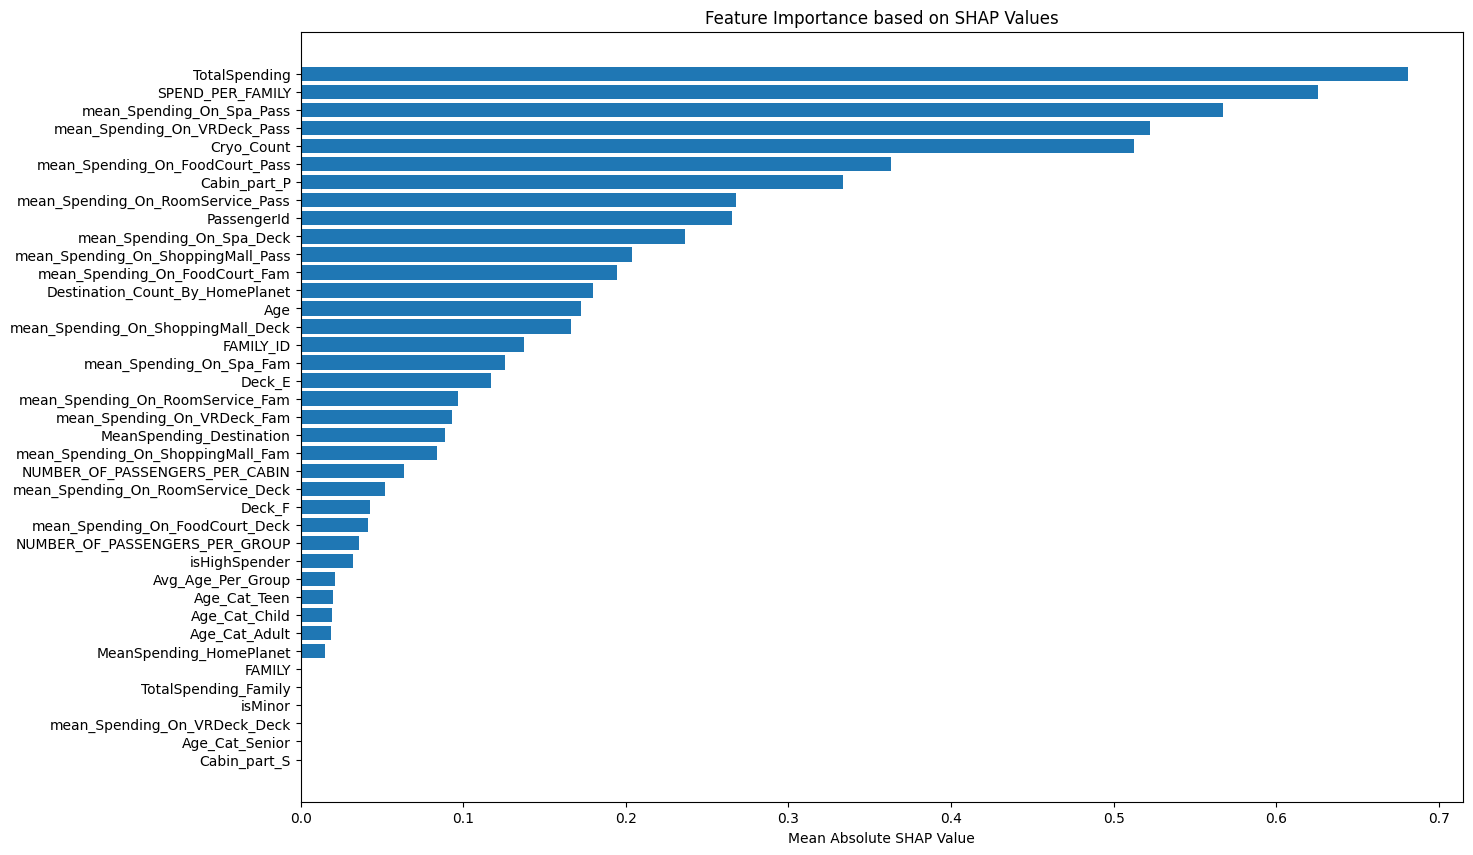

In [36]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

explainer_xgb = shap.Explainer(xgb_model)
shap_explanation = explainer_xgb(X_test)

shap_importance = np.abs(shap_explanation.values).mean(axis=0)

importance_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP': shap_importance})
importance_df = importance_df.sort_values(by='SHAP', ascending=False)

plt.figure(figsize=(15,10))
plt.barh(importance_df['Feature'], importance_df['SHAP'])
plt.gca().invert_yaxis()
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance based on SHAP Values')
plt.show()


In [25]:
gbc_best_optuna_params = Modeller.tune_model('GradientBoostingClassifier', X_train=X_train, y_train=y_train, n_trials=300)
xgb_best_optuna_params = Modeller.tune_model('XGBClassifier', X_train=X_train, y_train=y_train, n_trials=300)
rfr_best_optuna_params = Modeller.tune_model('RandomForestClassifier', X_train=X_train, y_train=y_train, n_trials=300)
lgbm_best_optuna_params = Modeller.tune_model('LGBMClassifier', X_train=X_train, y_train=y_train, n_trials=300)
hgbc_best_optuna_params = Modeller.tune_model('HistGradientBoostingClassifier', X_train=X_train, y_train=y_train, n_trials=300)

Best parameters for GradientBoostingClassifier: {'n_estimators': 450, 'learning_rate': 0.016990824284927153, 'max_depth': 5, 'subsample': 0.7213034145791403, 'min_samples_split': 20, 'min_samples_leaf': 7}
Best score for GradientBoostingClassifier: 0.811113419812585
Best parameters for XGBClassifier: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.048434796968319704, 'subsample': 0.872820346645651, 'colsample_bytree': 0.7736180120285302, 'gamma': 1.2295777439848676, 'reg_alpha': 1.0964742045115137, 'reg_lambda': 8.398626587163827, 'scale_pos_weight': 0.9867861910737088, 'min_child_weight': 1}
Best score for XGBClassifier: 0.8118028098367447
Best parameters for RandomForestClassifier: {'n_estimators': 389, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'entropy', 'max_leaf_nodes': 100}
Best score for RandomForestClassifier: 0.7999540097843358
Best parameters for LGBMClassifier: {'n_estimators': 458, 'max_depth': 8, 'learning_rate

In [26]:
clf1 = RandomForestClassifier(**rfr_best_optuna_params)
clf2 = LGBMClassifier(**lgbm_best_optuna_params)
clf3 = XGBClassifier(**xgb_best_optuna_params)
clf4 = HistGradientBoostingClassifier(**hgbc_best_optuna_params)
clf5 = GradientBoostingClassifier(**gbc_best_optuna_params)
eclf1 = VotingClassifier(estimators=[('rfr', clf1), ('lgb', clf2), ('xgb', clf3), ('hgbc', clf4), ('sgd', clf5)], voting='soft', weights=[0.75, 0.90, 0.85, 0.95, 0.80]) # rf 80, lgb 81.1, hgb 81.3 xgb 81.1
eclf1.fit(X_train, y_train)

c:\Users\marca\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\marca\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3791
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

VotingClassifier(estimators=[('rfr',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=15,
                                                     max_leaf_nodes=100,
                                                     min_samples_leaf=3,
                                                     min_samples_split=5,
                                                     n_estimators=389)),
                             ('lgb',
                              LGBMClassifier(colsample_bytree=0.5834396121689654,
                                             learning_rate=0.1635249980781021,
                                             max_depth=8, min_child_samples=13,
                                             n_estimators=458, num_leaves=201,
                                             reg_alpha=9.7858608159363...
                                                             l2_regularization=7.118399253067811,
                                                             learning_rate=0.023358088003984766,
                                                             max_bins=138,
                                                             max_depth=14,
                                                             max_iter=511,
                                                             max_leaf_nodes=18,
                                                             min_samples_leaf=41)),
                             ('sgd',
                              GradientBoostingClassifier(learning_rate=0.016990824284927153,
                                                         max_depth=5,
                                                         min_samples_leaf=7,
                                                         min_samples_split=20,
                                                         n_estimators=450,
                                                         subsample=0.7213034145791403))],
                 voting='soft', weights=[0.75, 0.9, 0.85, 0.95, 0.8])

In [27]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
test['Transported'] = Modeller.predict_test_set(model = eclf1, X_test=X_test[X_train.columns])
test['Transported'] = test['Transported'].apply(lambda x: True if x == 1 else False)
submission = test[['PassengerId', 'Transported']]
submission.to_csv("submission.csv", index=False)